# Recepie Review and User Feedback Dataset

# CRIPS - DM Methodology
 1. Bussiness Understanding.
 2. Data Understanding. 
 3. Data Preparation.
 4. Modelling. 
 5. Evaluation. 
 6. Deplotment.

#### 1.Bussiness Understanding


- Recepies names information.
- The recepies has ranking on the top 100 best.
- Internal user reputation score (might have different weights based on their reputation)
- Comments has unique ID (most import up-votes).
- qualify sentimen 1 to 5 / 0 denoting absence of rating

- Bussiness can develop recomender systems 
- Bussiness can develop behavior analysis 

In this step, we'll explore our recipe reviews dataset to understand:
1. Data structure and composition
2. Distribution of ratings and reviews
3. Text characteristics and patterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Any
from pathlib import Path

# Set up for plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Set random seed for reproducibility
np.random.seed(98)

c:\Users\geova\.conda\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load and Validate Dataset

In [2]:
def load_dataset(path: str) -> pd.DataFrame:
    """
    Load the recipe reviews dataset with proper types and validations.
    
    Args:
        path: Path to the dataset file
        
    Returns:
        Loaded and validated DataFrame
    """
    try:
        df = pd.read_csv(path)
        print(f"Dataset loaded successfully with shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

# Load dataset
df = load_dataset("../data/raw/Recipe Reviews and User Feedback Dataset.csv")

Dataset loaded successfully with shape: (18182, 15)


Basic Data Information

In [3]:
# Display basic information about the dataset
print("\nDataset Information:")
print("-" * 50)
df.info()

# Display first few rows
print("\nFirst few rows of the dataset:")
display(df.head())


Dataset Information:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB

F

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


Analyze Data Distribution


Numerical Features Summary:
       Unnamed: 0  recipe_number  recipe_code  user_reputation    created_at  \
count    18182.00       18182.00     18182.00         18182.00  1.818200e+04   
mean       121.47          38.69     21773.67             2.16  1.623710e+09   
std        116.75          29.79     23965.11            10.01  5.468697e+06   
min          0.00           1.00       386.00             0.00  1.613035e+09   
25%         45.00          12.00      6086.00             1.00  1.622717e+09   
50%         91.00          33.00     14600.00             1.00  1.622718e+09   
75%        150.00          64.00     33121.00             1.00  1.622718e+09   
max        724.00         100.00    191775.00           520.00  1.665756e+09   

       reply_count  thumbs_up  thumbs_down     stars  best_score  
count     18182.00   18182.00     18182.00  18182.00    18182.00  
mean          0.01       1.09         0.55      4.29      153.16  
std           0.14       4.20         3.47      1

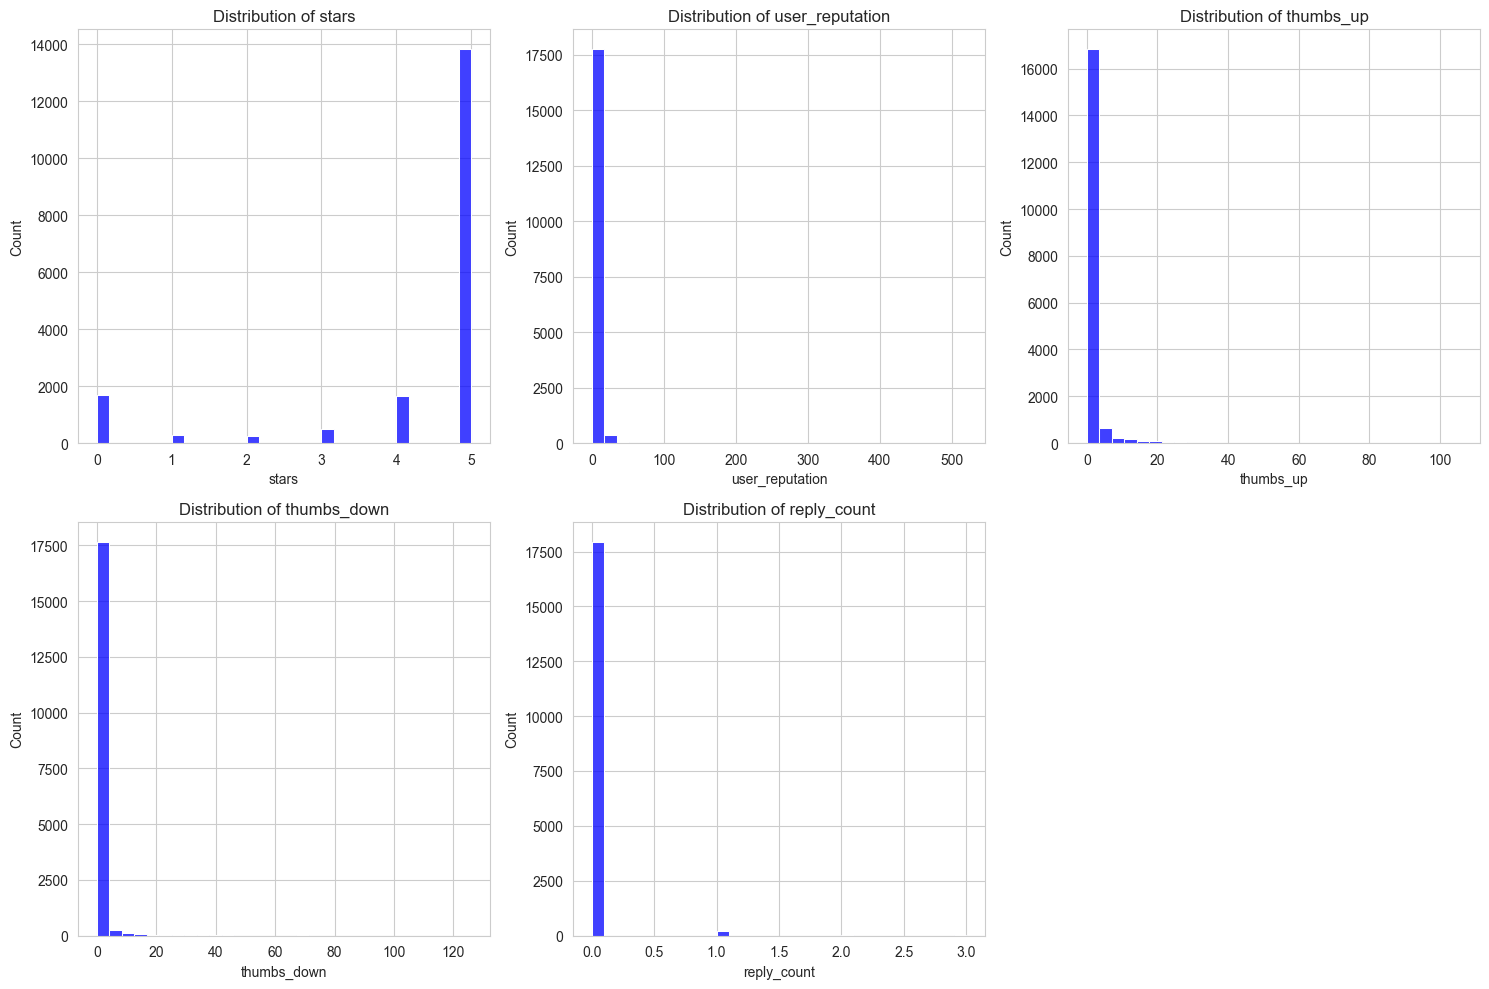

In [4]:
def analyze_data_distributions(df: pd.DataFrame) -> None:
    """
    Analyze and visualize the distribution of key features.
    
    Args:
        df: Input DataFrame
    """
    print("\nNumerical Features Summary:")
    print(df.describe().round(2))
    
    # Distribution of numerical features
    numerical_features = ['stars', 'user_reputation', 'thumbs_up', 'thumbs_down', 'reply_count']
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df, x=feature, bins=30, color='blue')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        
    plt.tight_layout()
    plt.savefig('../reports/figures/Task_3/numerical_distributions.png')
    plt.show()
    plt.close()

# Run distribution analysis
analyze_data_distributions(df)

Engagement Analysis

Engagement Analysis

C:\Users\geova\AppData\Local\Temp\ipykernel_18656\97611898.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stars', y='engagement_score', palette='Blues')
C:\Users\geova\AppData\Local\Temp\ipykernel_18656\97611898.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stars', y='reply_count', palette='Blues')
C:\Users\geova\AppData\Local\Temp\ipykernel_18656\97611898.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stars', y='interaction_rate', palette='Blues')


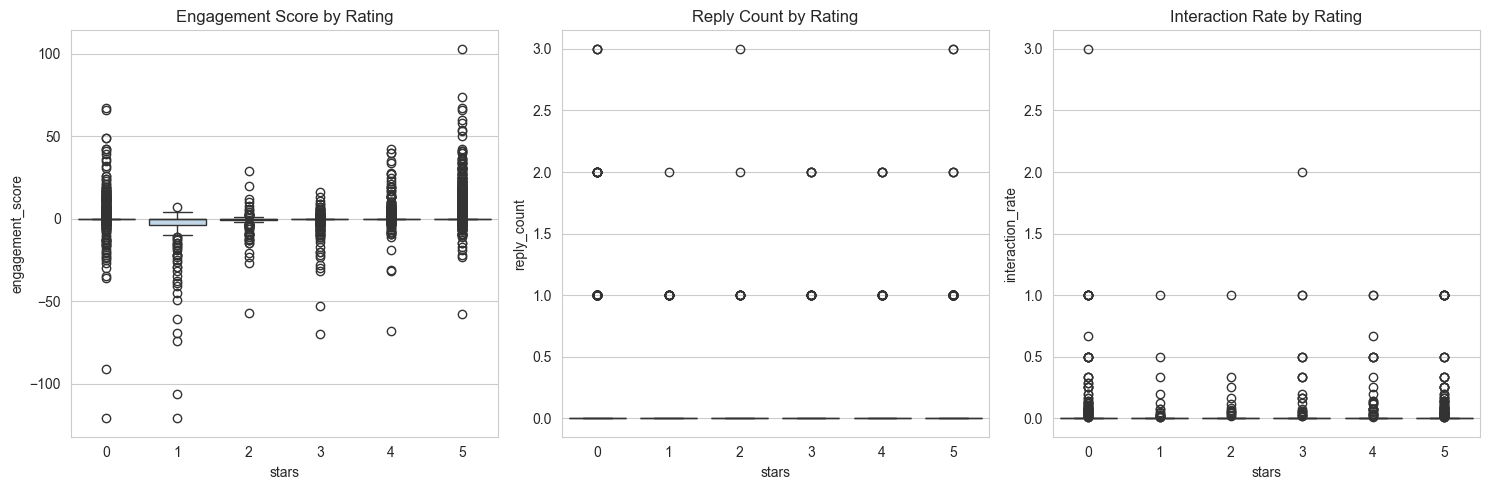

In [5]:
def analyze_engagement_patterns(df: pd.DataFrame) -> None:
    """
    Analyze user engagement patterns across different ratings.
    
    Args:
        df: Input DataFrame
    """
    # Calculate engagement metrics
    df['engagement_score'] = df['thumbs_up'] - df['thumbs_down']
    df['interaction_rate'] = df['reply_count'] / (df['thumbs_up'] + df['thumbs_down'] + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Engagement by rating
    plt.subplot(1, 3, 1)
    sns.boxplot(data=df, x='stars', y='engagement_score', palette='Blues')
    plt.title('Engagement Score by Rating')
    
    # Reply count by rating
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, x='stars', y='reply_count', palette='Blues')
    plt.title('Reply Count by Rating')
    
    # Interaction rate by rating
    plt.subplot(1, 3, 3)
    sns.boxplot(data=df, x='stars', y='interaction_rate', palette='Blues')
    plt.title('Interaction Rate by Rating')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/Task_3/engagement_analysis.png')
    plt.show()
    plt.close()

# Run engagement analysis
analyze_engagement_patterns(df)

 Text Analysis

c:\Users\geova\.conda\envs\deep_learning\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\geova\.conda\envs\deep_learning\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\geova\AppData\Local\Temp\ipykernel_18656\2328980856.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stars', y='text_length', ax=axes[1, 1], palette='Blues')


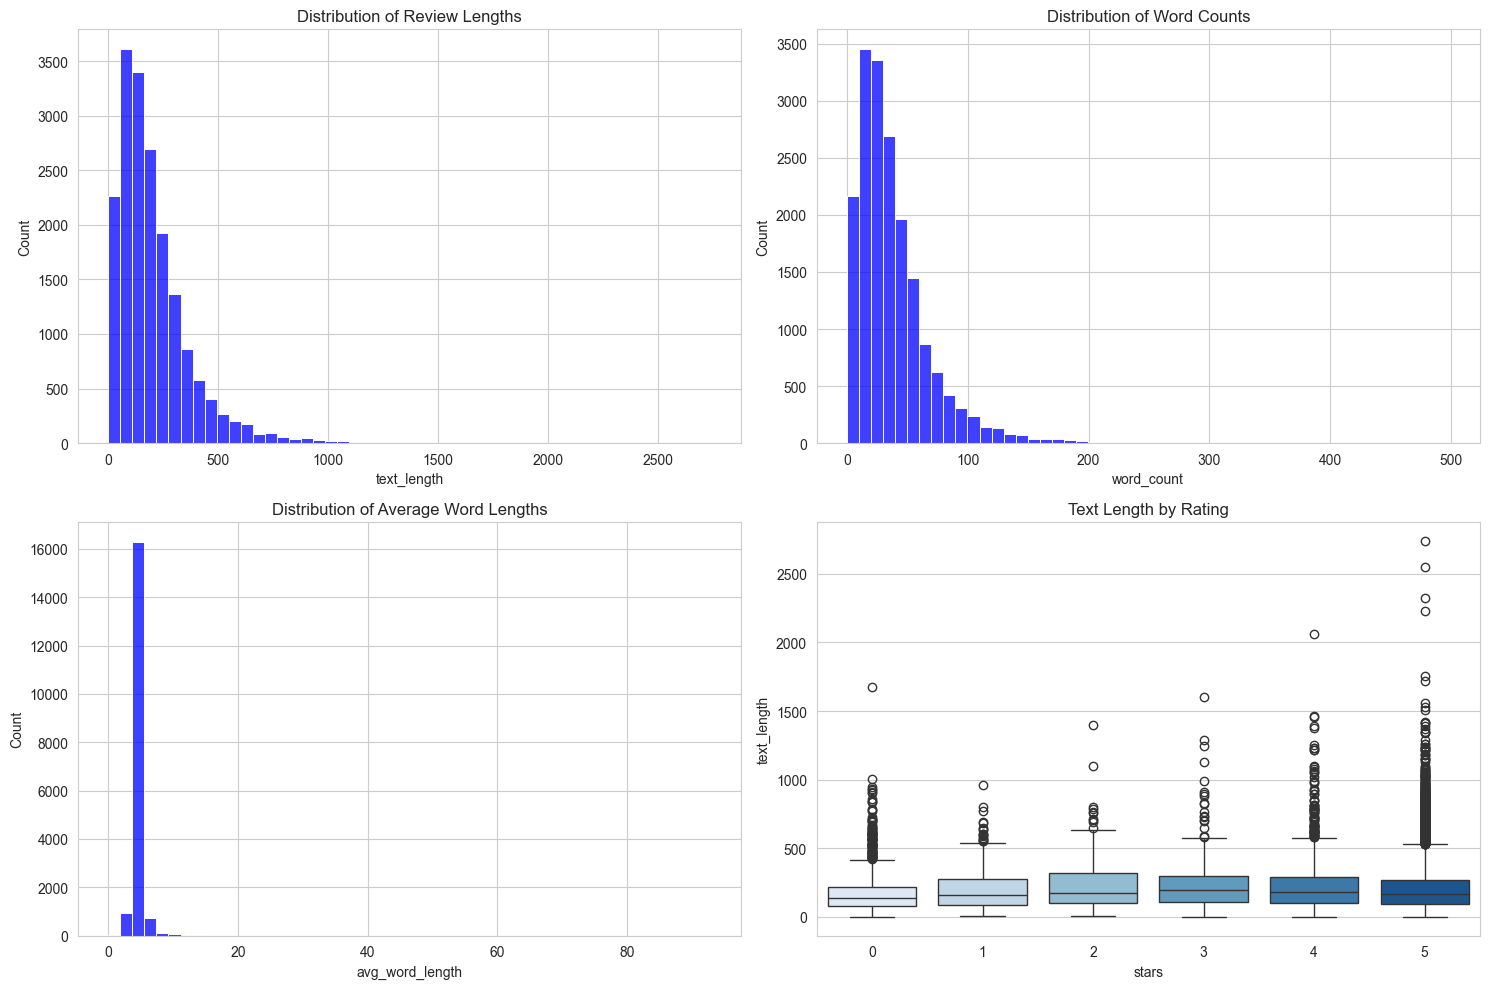


Text Features Summary:
       text_length  word_count  avg_word_length
count     18182.00    18182.00         18179.00
mean        203.89       37.81             4.54
std         172.47       32.09             1.40
min           0.00        0.00             0.00
25%          90.00       16.00             4.12
50%         161.00       30.00             4.40
75%         266.00       49.00             4.73
max        2742.00      499.00            93.00


In [6]:
def analyze_text_features(df: pd.DataFrame) -> None:
    """
    Analyze characteristics of review text content.
    
    Args:
        df: Input DataFrame
    """
    # Calculate text features
    df['text_length'] = df['text'].fillna('').str.len()
    df['word_count'] = df['text'].fillna('').str.split().str.len()
    df['avg_word_length'] = df['text'].fillna('').apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x)) > 0 else 0
    )
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Text length distribution
    sns.histplot(data=df, x='text_length', bins=50, ax=axes[0, 0], color='blue')
    axes[0, 0].set_title('Distribution of Review Lengths')
    
    # Word count distribution
    sns.histplot(data=df, x='word_count', bins=50, ax=axes[0, 1], color='blue')
    axes[0, 1].set_title('Distribution of Word Counts')
    
    # Average word length
    sns.histplot(data=df, x='avg_word_length', bins=50, ax=axes[1, 0], color='blue')
    axes[1, 0].set_title('Distribution of Average Word Lengths')
    
    # Text length by rating
    sns.boxplot(data=df, x='stars', y='text_length', ax=axes[1, 1], palette='Blues')
    axes[1, 1].set_title('Text Length by Rating')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/Task_3/text_analysis.png')
    plt.show()
    plt.close()
    
    # Print summary statistics
    print("\nText Features Summary:")
    print(df[['text_length', 'word_count', 'avg_word_length']].describe().round(2))

# Run text analysis
analyze_text_features(df)

 Temporal Analysis

C:\Users\geova\AppData\Local\Temp\ipykernel_18656\984895775.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=df['hour'].astype(str), y='stars', palette='Blues')
C:\Users\geova\AppData\Local\Temp\ipykernel_18656\984895775.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='day_of_week', y='stars', palette='Blues')
C:\Users\geova\AppData\Local\Temp\ipykernel_18656\984895775.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='hour', y='engagement_score', ci=95, color='blue')


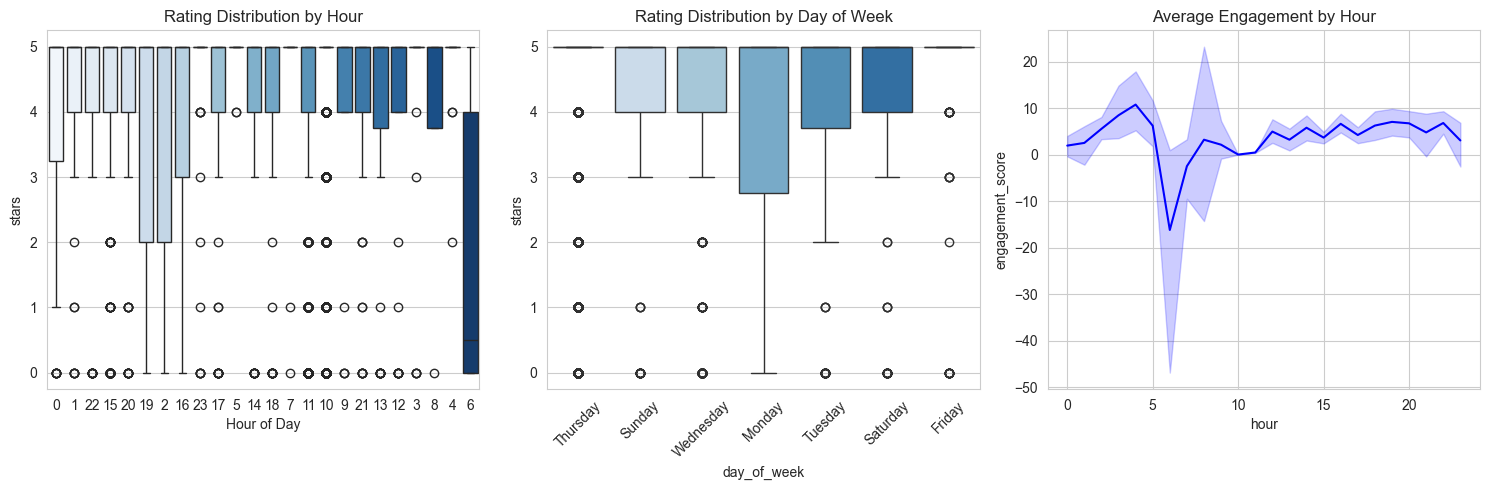

In [7]:
def analyze_temporal_patterns(df: pd.DataFrame) -> None:
    """
    Analyze temporal patterns in reviews and ratings.
    
    Args:
        df: Input DataFrame
    """
    # Convert timestamp to datetime
    df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.day_name()
    
    plt.figure(figsize=(15, 5))
    
    # Ratings by hour
    plt.subplot(1, 3, 1)
    sns.boxplot(data=df, x=df['hour'].astype(str), y='stars', palette='Blues')
    plt.title('Rating Distribution by Hour')
    plt.xlabel('Hour of Day')
    
    # Ratings by day of week
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, x='day_of_week', y='stars', palette='Blues')
    plt.title('Rating Distribution by Day of Week')
    plt.xticks(rotation=45)
    
    # Average engagement by hour
    plt.subplot(1, 3, 3)
    sns.lineplot(data=df, x='hour', y='engagement_score', ci=95, color='blue')
    plt.title('Average Engagement by Hour')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/Task_3/temporal_analysis.png')
    plt.show()
    plt.close()

# Run temporal analysis
analyze_temporal_patterns(df)

Save Processed Data

In [8]:
def save_processed_data(df: pd.DataFrame) -> None:
    """
    Save the processed DataFrame with engineered features.
    
    Args:
        df: Processed DataFrame
    """
    processed_path = "../data/processed/Task_3_processed/processed_reviews.csv"
    Path(processed_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(processed_path, index=False)
    print(f"Processed data saved to: {processed_path}")

# Save the processed dataset
save_processed_data(df)

Processed data saved to: ../data/processed/Task_3_processed/processed_reviews.csv


# 3. Data Preparation

### CRISP-DM Data Preparation Stage
1. Text Preprocessing 
   - Clean text (remove HTML, special chars)
   - Normalize text
   - Handle missing values
   - Tokenization

2. Feature Engineering
   - Text-based features
   - User engagement metrics
   - Temporal features
   - Normalized ratings

3. Data Quality
   - Handle imbalanced classes
   - Remove outliers
   - Validate features
   - Cross-validation splits

4. Feature Selection/Extraction
   - TF-IDF vectorization
   - Word embeddings
   - Feature importance analysis
   - Dimensionality reduction

### Implementation Steps:
3.1 Text Preprocessing
3.2 Feature Engineering
3.3 Feature Extraction
3.4 Data Validation
3.5 Save Processed Data

### Key Outputs:
- Cleaned text data
- Engineered features
- Vectorized features 
- Train/val/test splits

In [9]:
def analyze_vader_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze sentiment using VADER.
    
    Args:
        df: Input DataFrame
    Returns:
        DataFrame with VADER scores
    """
    sia = SentimentIntensityAnalyzer()
    
    # Run VADER analysis
    res = {}
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = str(row['text'])
        review_id = row['comment_id']
        res[review_id] = sia.polarity_scores(text)
    
    # Convert to DataFrame
    vader_df = pd.DataFrame(res).T
    vader_df = vader_df.reset_index().rename(columns={'index': 'comment_id'})
    vader_df = vader_df.merge(df, on='comment_id')
    
    # Save intermediate results
    vader_df.to_csv('../data/processed/Task_3_processed/vader_scores.csv', index=False)
    
    return vader_df

# Run VADER analysis
vader_results = analyze_vader_sentiment(df)

100%|██████████| 18182/18182 [00:06<00:00, 2670.78it/s]


In [10]:
# Initialize both VADER and RoBERTa
sia = SentimentIntensityAnalyzer()
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

RuntimeError: Failed to import transformers.models.roberta.modeling_roberta because of the following error (look up to see its traceback):
Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:
def get_roberta_scores(text: str) -> Dict[str, float]:
    """Get RoBERTa sentiment scores for a text."""
    try:
        encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        return {
            'roberta_neg': scores[0],
            'roberta_neu': scores[1],
            'roberta_pos': scores[2]
        }
    except Exception as e:
        print(f"Error in RoBERTa scoring: {str(e)}")
        return {'roberta_neg': 0, 'roberta_neu': 0, 'roberta_pos': 0}

def get_vader_scores(text: str) -> Dict[str, float]:
    """Get VADER sentiment scores for a text."""
    try:
        scores = sia.polarity_scores(text)
        return {f"vader_{k}": v for k, v in scores.items()}
    except Exception as e:
        print(f"Error in VADER scoring: {str(e)}")
        return {'vader_neg': 0, 'vader_neu': 0, 'vader_pos': 0, 'vader_compound': 0}

In [ ]:
def analyze_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze sentiment using both VADER and RoBERTa.
    
    Args:
        df: Input DataFrame
    Returns:
        DataFrame with both VADER and RoBERTa scores
    """
    results = {}
    
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            text = str(row['text'])
            review_id = row['comment_id']
            
            # Get both scores
            vader_scores = get_vader_scores(text)
            roberta_scores = get_roberta_scores(text)
            
            # Combine scores
            results[review_id] = {**vader_scores, **roberta_scores}
            
        except Exception as e:
            print(f"Error processing review {review_id}: {str(e)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={'index': 'comment_id'})
    
    # Merge with original data
    final_df = results_df.merge(df, on='comment_id', how='left')
    
    return final_df

# Run sentiment analysis
print("Starting sentiment analysis...")
sentiment_results = analyze_sentiment(df)

Starting sentiment analysis...


100%|██████████| 18182/18182 [14:33<00:00, 20.81it/s]


In [ ]:
# Save results
output_path = '../data/processed/Task_3_processed/sentiment_scores.csv'
sentiment_results.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Show sample results
print("\nSample results:")
print(sentiment_results[['comment_id', 'stars', 'vader_compound', 
                        'roberta_pos', 'roberta_neu', 'roberta_neg']].head())

Results saved to: ../data/processed/Task_3_processed/sentiment_scores.csv

Sample results:
                                        comment_id  stars  vader_compound  \
0  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM      5          0.8881   
1  sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY      5          0.6360   
2  sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP      5          0.9437   
3  sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC      0          0.0000   
4  sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI      0          0.6114   

   roberta_pos  roberta_neu  roberta_neg  
0     0.981031     0.016349     0.002621  
1     0.581237     0.408563     0.010201  
2     0.961051     0.034999     0.003950  
3     0.074891     0.559332     0.365777  
4     0.972595     0.026291     0.001114  


In [ ]:
def validate_results(results_df: pd.DataFrame) -> None:
    """Validate the sentiment analysis results."""
    print("\nValidation Summary:")
    print("-" * 50)
    
    # Check for missing values
    print("\nMissing values:")
    print(results_df[['vader_compound', 'roberta_pos', 'roberta_neg', 'roberta_neu']].isnull().sum())
    
    # Check score ranges
    print("\nScore ranges:")
    for col in ['vader_compound', 'roberta_pos', 'roberta_neg', 'roberta_neu']:
        print(f"{col}:")
        print(f"  Range: [{results_df[col].min():.3f}, {results_df[col].max():.3f}]")
        print(f"  Mean: {results_df[col].mean():.3f}")

# Validate results
validate_results(sentiment_results)


Validation Summary:
--------------------------------------------------

Missing values:
vader_compound    0
roberta_pos       0
roberta_neg       0
roberta_neu       0
dtype: int64

Score ranges:
vader_compound:
  Range: [-0.960, 0.996]
  Mean: 0.666
roberta_pos:
  Range: [0.002, 0.994]
  Mean: 0.842
roberta_neg:
  Range: [0.001, 0.984]
  Mean: 0.053
roberta_neu:
  Range: [0.004, 0.943]
  Mean: 0.104


In [ ]:
def create_sentiment_visualizations(results_df: pd.DataFrame) -> None:
    """
    Create comprehensive visualizations of sentiment analysis results.
    
    Args:
        results_df: DataFrame with sentiment scores
    """
    # Set up plots theme
    plt.style.use('ggplot')
    sns.set_palette("Blues")
    
    # 1. VADER vs RoBERTa by Star Rating
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=results_df, x='stars', y='vader_compound')
    plt.title('VADER Compound Score by Star Rating')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=results_df, x='stars', y='roberta_pos')
    plt.title('RoBERTa Positive Score by Star Rating')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/Task_3/sentiment_by_rating.png')
    plt.close()

In [ ]:
def analyze_model_agreement(results_df: pd.DataFrame) -> None:
    """
    Analyze agreement between VADER and RoBERTa models.
    
    Args:
        results_df: DataFrame with sentiment scores
    """
    # Convert VADER compound to positive/negative/neutral
    results_df['vader_sentiment'] = pd.cut(
        results_df['vader_compound'],
        bins=[-1, -0.05, 0.05, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )
    
    # Get RoBERTa sentiment based on highest score
    results_df['roberta_sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1)
    results_df['roberta_sentiment'] = results_df['roberta_sentiment'].map({
        'roberta_neg': 'Negative',
        'roberta_neu': 'Neutral',
        'roberta_pos': 'Positive'
    })
    
    # Calculate agreement
    agreement = (results_df['vader_sentiment'] == results_df['roberta_sentiment']).mean()
    
    print("\nModel Agreement Analysis:")
    print("-" * 50)
    print(f"Overall agreement between models: {agreement:.2%}")
    
    # Create agreement matrix
    agreement_matrix = pd.crosstab(
        results_df['vader_sentiment'],
        results_df['roberta_sentiment'],
        normalize='index'
    )
    
    print("\nAgreement Matrix (normalized by VADER predictions):")
    print(agreement_matrix)
    
    # Visualize agreement
    plt.figure(figsize=(8, 6))
    sns.heatmap(agreement_matrix, annot=True, cmap='Blues', fmt='.2%')
    plt.title('Model Agreement Matrix')
    plt.savefig('../reports/figures/Task_3/model_agreement.png')
    plt.close()

In [ ]:
def analyze_edge_cases(results_df: pd.DataFrame) -> None:
    """
    Analyze cases where models strongly disagree or produce unexpected results.
    
    Args:
        results_df: DataFrame with sentiment scores
    """
    # Find cases where models strongly disagree
    results_df['model_disagreement'] = abs(
        results_df['vader_compound'] - results_df['roberta_pos']
    )
    
    print("\nEdge Cases Analysis:")
    print("-" * 50)
    print("\nTop 5 cases where models strongly disagree:")
    
    disagreement_cases = results_df.nlargest(5, 'model_disagreement')
    for _, case in disagreement_cases.iterrows():
        print(f"\nRating: {case['stars']}")
        print(f"VADER Compound: {case['vader_compound']:.3f}")
        print(f"RoBERTa Positive: {case['roberta_pos']:.3f}")
        print(f"Text: {case['text'][:200]}...")

In [ ]:
# Load results if needed
sentiment_results = pd.read_csv('../data/processed/Task_3_processed/sentiment_scores.csv')

# Run analyses
create_sentiment_visualizations(sentiment_results)
analyze_model_agreement(sentiment_results)
analyze_edge_cases(sentiment_results)